**EM Algorithm** (Expectation - Maximization)

We're going to implement the EM algorithm for a mixture of Bernoullis

The Expectation-Maximization algo. is used in sk-learn, for instance in GMMs: http://scikit-learn.org/stable/modules/mixture.html#estimation-algorithm-expectation-maximization

Additional notes are available here: https://allauzen.github.io/articles/MixturesAndEM/


## Think for a bit

Is EM a supervised or unsupervised learning algorithm ? 

What kind of data set is MNIST ? 

Then, what are we going to do ?  How is this called ?



## Implement the EM algo. for a mixture of Bernoulli (laws)
- The cluster number K should be an argument of the function
- A maximum number of iterations, *MaxIt*, should act as stopping condition
- During the E step, compute and *store* the log-likelihood of the data, so as to monitor its evolution along iterations (~epochs)

Apply the algorithm on MNIST:
- try out K=5,10,15
- Visualize the images coresponding to each cluster's paraemeters. Would that be as straightforward in a Gaussian model (visualizing all the model's parameters?)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

In [2]:
## we load the whole data set at once, so as to manipulate it directly (using numpy arrays)
## for very large data sets, one needs to read on-the-fly (at least at production time, not at the debugging stage)

import numpy as np
data = np.load('/home/flandes/data/mnist70.npz', 'X', 'y')
X = data['X']
y = data['y']
print(X.shape)

import sklearn.model_selection
X, Xtest, y, test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
# del y



(70000, 784)


In [3]:
X.shape

(46900, 784)

In [4]:
## compute the proba of an image xi, 
## given its cluster k and parameters theta 
def compute_P_Xi_given_k_and_theta(xi, k, theta):
    EPS = 1e-15
    ### loop version: ~100x slower
    # D = (xi.shape)[0]
    # output = 0.0
    # for j in range(D):
    #     output += xi[j]*np.log(theta[k,j]+EPS) + (1.0-xi[j])*np.log(1-theta[k,j]+EPS)
    ### numpy version: much much faster ! 
    output = np.dot(xi, np.log(theta[k]+EPS)) +  np.dot( 1.0-xi, np.log(1-theta[k]+EPS) )
    return np.exp(output)
# outputForDebug = compute_P_Xi_given_k_and_theta(xi, k, theta)

In [5]:
## python-note: at debug time, don't write a function, instead, write directly in the main
## when evreything works well, encapsulate the piece of code into a function for later re-use (and lisibility)
K=10
MaxIt=5

#def AlgoEM(X, K, MaxIt, subSampledLabels):
## we set the seed to a constant so as to have repeatable experiences 
## (at debug time, and when comparing hyper-parameters)
np.random.seed(42)

## we'll assume X[i,j] is the value of pixel j of image i.
N = (X.shape)[0] ## number of examples (= number of images)
D = (X.shape)[1] ## dimension of parameters space (=number of pixels per image, in the Bernoulli case)

## initialization ##
## here we do: random affectations (not advised)
## (in that case, we perform the M step first, then E step)
affectations = np.random.random((K, N)) ## denoted a_{k,i}
affectations /= np.sum(affectations, axis=0)
classFrequencies = np.zeros(K) ## denoted pi_k 
theta = np.zeros((K, D))   ## denoted theta_{k,j}
  
## main loop ##
for iteration in range(0,MaxIt,1):
    ######################
    ## step M: update of "pi_k, mu_k" (classFrequencies, theta)  ##
    ## update pi_k:
    for k in range(K):
        classFrequencies[k] = np.sum(affectations[k,:])/N
    ## update theta[k,j]:  (using the very efficient numpy matrix product)
    theta = np.matmul(affectations, X) ## theta[k,j]  =  sum_i affectations[k,i]*X[i,j]
    for k in range(K):
        theta[k,:] /= (N*classFrequencies[k])
             
    ######################
    ## step E: update of "a_ik" (affectations) ##
    
    ### semi-numpy version: (much slower)
    # for i in range(N):
    #     xi = X[i]
    #     for k in range(K):
    #         temporary = compute_P_Xi_given_k_and_theta(xi,k, theta)
    #         affectations[k,i] = classFrequencies[k]*temporary
    #     affectations[:,i] /= np.sum(affectations[:,i]) ## divide by the total (denominator)
    
    ### fully-numpy version : (much faster)
    for k in range(K):
        temporary = compute_P_Xi_given_k_and_theta(X,k, theta)
        affectations[k] = classFrequencies[k]*temporary    
    affectations /= np.sum(affectations,axis=0) ## divide by the total (denominator)
    
    ## monitoring of the quality of te clustering ##
    LogLikelihood = np.log(np.max(affectations, axis=0)) 
    print(np.mean(LogLikelihood))
##########################################################################


-2.1044472596954815
-0.5573828561209827
-0.03903414227330352
-0.020077853826047407
-0.017676995101866263


In [6]:
classFrequencies

array([0.19742949, 0.06410866, 0.14570021, 0.0759597 , 0.07153046,
       0.10592062, 0.1022654 , 0.09764506, 0.06257916, 0.07686122])

In [7]:
np.sum(affectations, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

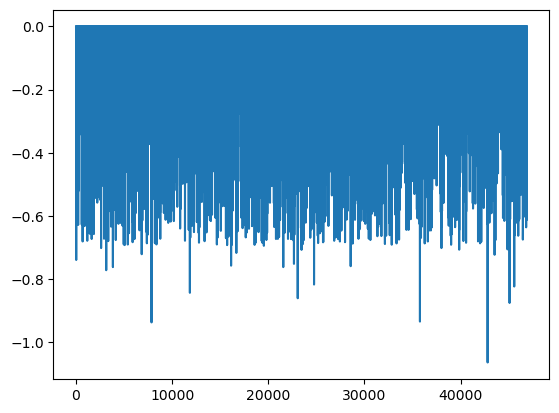

In [8]:
plt.plot(np.log(np.max(affectations, axis=0)) )  #log-likelihood

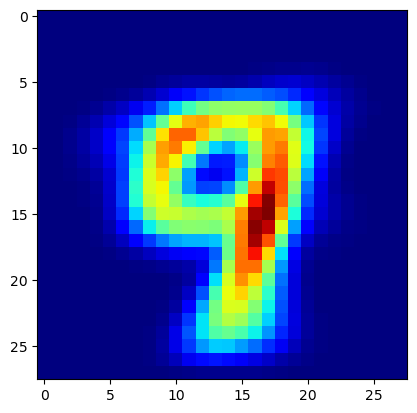

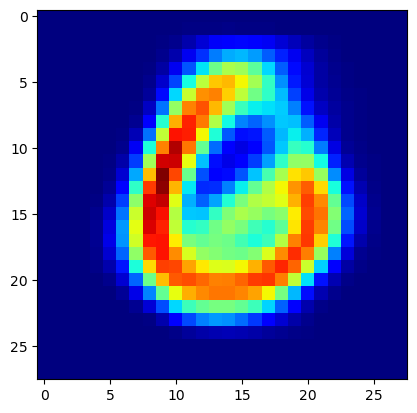

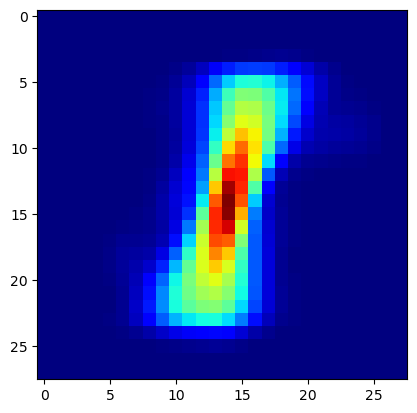

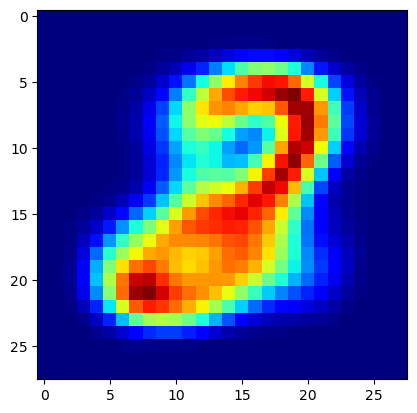

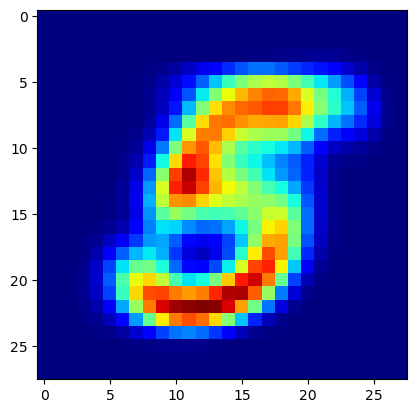

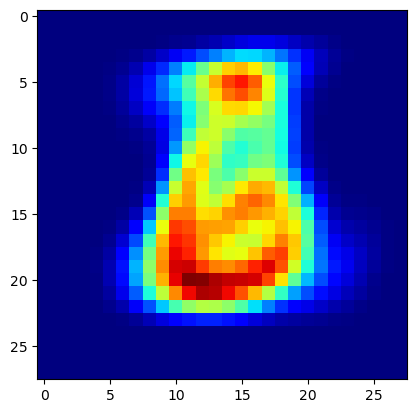

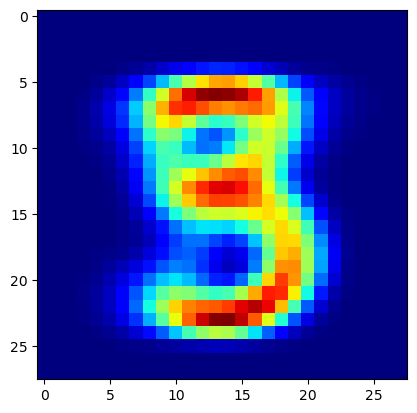

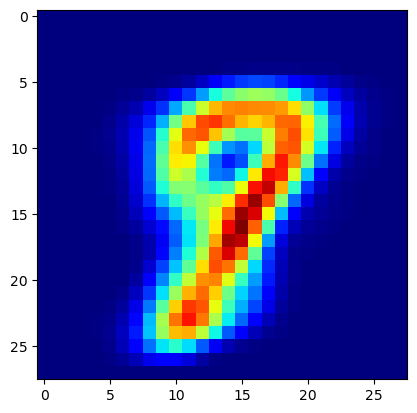

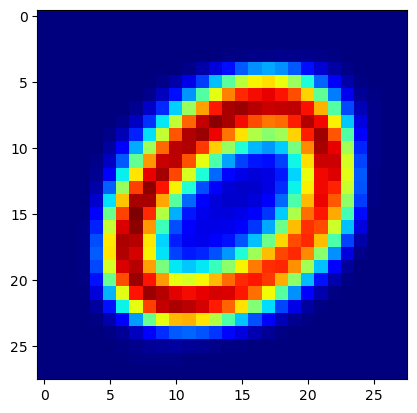

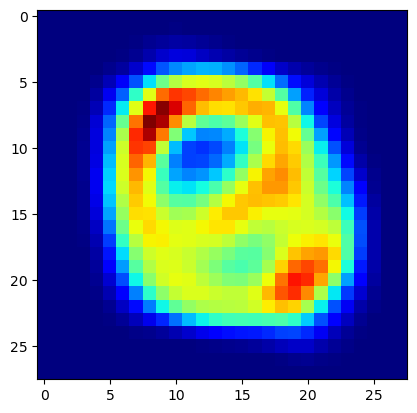

In [9]:
## we can visualize the parameters theta, cluster by cluster
for k in range(K):
    plt.imshow(theta[k].reshape(28,28) , matplotlib.pyplot.cm.jet)
    matplotlib.pyplot.show()

Now, let's monitor something more interpretable than the log-likelihood... what could it be ? 

Trick: you may use the function np.argmax(), and maybe just a couple of labels from a couple of examples

**Question**: would this strategy be possible for a purely unsupervised task ?

## ANSWER: we can get the class corresponding best to each cluster, then compute an error rate !

And no, it is only possible if we have access to at least some of the labels ! (not possible in a truly unsupervised task)

In [10]:
## 1st attempt to assign a class to each cluster ##
## for each cluster (1...K), the most certainly-assigned data point (single image) is the image number:
print(" for each cluster (1...K), the most certainly-assigned data point (single image) is the timage number:", \
      np.argmax(affectations,axis=1))
print("the corresponding labels are:", y[np.argmax(affectations,axis=1)])
print("ok, so this will not work out...")

 for each cluster (1...K), the most certainly-assigned data point (single image) is the timage number: [ 57 149   3   6  29   4   0  24  15   2]
the corresponding labels are: [9 6 1 3 5 2 3 7 0 2]
ok, so this will not work out...


In [11]:
y.shape

(46900,)

In [12]:
## 2nd attempt to assign a class to each cluster ##
affected_cluster = np.argmax(affectations,axis=0)
print("here is an example of what np.bincount does:", y[affected_cluster == 0], np.bincount(y[affected_cluster == 0]))
predictedClass = np.zeros(K, dtype=int)
for k in range(K):
    predictedClass[k] = np.argmax(np.bincount(y[affected_cluster == k]))   
    print("cluster ",k," represents (probably) the class (digit number) : ",predictedClass[k] )


here is an example of what np.bincount does: [9 7 4 ... 4 7 7] [   1   11   38   93 2761  196    2 2732  103 2894]
cluster  0  represents (probably) the class (digit number) :  9
cluster  1  represents (probably) the class (digit number) :  6
cluster  2  represents (probably) the class (digit number) :  1
cluster  3  represents (probably) the class (digit number) :  2
cluster  4  represents (probably) the class (digit number) :  5
cluster  5  represents (probably) the class (digit number) :  6
cluster  6  represents (probably) the class (digit number) :  3
cluster  7  represents (probably) the class (digit number) :  7
cluster  8  represents (probably) the class (digit number) :  0
cluster  9  represents (probably) the class (digit number) :  2


In [13]:
predictedClass

array([9, 6, 1, 2, 5, 6, 3, 7, 0, 2])

In [14]:
ypred = np.zeros(N)
for k in range(K):
    ypred[affected_cluster == k] = predictedClass[k]

In [15]:
np.unique(ypred)

array([0., 1., 2., 3., 5., 6., 7., 9.])

In [16]:
## we are missing the numbers 4 and 8...
## what can we do to incresae the chances that we cover all expected classes in our clusters ?

In [17]:
## avreage (train) accuracy:
(ypred == y).mean()

0.5008742004264393

### conclusion: on semi-supervised learning

well, 50% is not excellent for 10 classes, but still better than random !

# OK, THIS WAS MOSTLY DEBUGGING-CODE. NOW THAT IT SEEMS TO WORK, WE CAN :
- put the code in a function (it's cleaner)
- use random initial parameters (rather than random initial affectations)
- use the whole data set (set subsampling=1 and re-load the data)
- "cheat" by doing semi-supervised learning: look at which cluster corresponds to which class (np.argmax(np.bincount( ...))) and then compute the error rate ! :) (here, I do it just on the training set, but you should do it for the test set.
- try various K values, see if some are better, understand why.

In [18]:
# ## for debugging, we may want to use a small piece of the sample
# ## data size will be divided by a factor "subSampling"
# subSampling = 10
# # subSampling = 10  # use more data for more accuracte results !
# ## in the end, we may use all of it (set this to 1) 

# ## sort data to make sure all classes are equally present ##
# ordre = np.argsort(labels_for_final_accuracy_measurement)
# unlabelled_dataset = unlabelled_dataset[ordre]
# labels_for_final_accuracy_measurement = labels_for_final_accuracy_measurement[ordre]

# ## do the sub-sampling
# X = unlabelled_dataset[::subSampling].copy()
# subSampledLabels = labels_for_final_accuracy_measurement[::subSampling].copy()

In [19]:
# def AlgoEM(X, K, MaxIt, subSampledLabels):
#     monitoring=list()
    
#     ## we set the seed to a constant so as to have repeatable experiences 
#     ## (at debug time, and when comparing hyper-parameters)
#     np.random.seed(42)

#     ## we'll assume X[i,j] is the value of pixel j of image i.
#     N = (X.shape)[0] ## number of examples (= number of images)
#     D = (X.shape)[1] ## dimension of parameters space (=number of pixels per image, in the Bernoulli case)

#     #### initialization ####
#     ## solution 1: random parameters
#     affectations = np.zeros((K, N)) ## denoted a_{k,i}
#     classFrequencies = np.random.random((K))
#     classFrequencies /= np.sum(classFrequencies) ## denoted pi_k 
#     theta = np.random.random((K, D))*0.5+0.25   ## denoted theta_{k,j}
#     plt.figure()
#     plt.hist(theta.flatten(), bins=100, label="Initial distribution of parameters, P(theta(j,k))")
#     plt.legend(loc="best")
#     plt.figure()
#     plt.plot(classFrequencies.flatten(), label="Initial values of pi_k")
#     plt.legend(loc="best")
#     print("initial pi_k: ",classFrequencies)
#     plt.show()
# #     ## solution 2: random affectations (not as advised)
# #     ## (in that case, perform the M step first, then E step)
# #     affectations = np.random.random((K, N)) ## denoted a_{k,i}
# #     affectations /= np.sum(affectations, axis=0)
# #     classFrequencies = np.zeros(K) ## denoted pi_k 
# #     theta = np.zeros((K, D))   ## denoted theta_{k,j}

    
#     #### main loop ####
#     for iteration in range(0,MaxIt,1):

#         ######################
#         ## step E: update of "a_ik" (affectations) ##
#         ### semi-numpy version: (much slower)
#         # for i in range(N):
#         #     xi = X[i]
#         #     for k in range(K):
#         #         temporary = compute_P_Xi_given_k_and_theta(xi,k, theta)
#         #         affectations[k,i] = classFrequencies[k]*temporary
#         #     affectations[:,i] /= np.sum(affectations[:,i]) ## divide by the total (denominator)
#         ### fully-numpy version : (much faster)
#         for k in range(K):
#             affectations[k] = classFrequencies[k] * compute_P_Xi_given_k_and_theta(X,k, theta)    
#         affectations /= np.sum(affectations,axis=0) ## divide by the total (denominator)
        
#         ######################
#         ## step M: update of "pi_k, mu_k" (classFrequencies, theta)  ##
#         ## update pi_k:
#         for k in range(K):
#             classFrequencies[k] = np.sum(affectations[k,:])/N
#         ## update theta[k,j]:  (using the very efficient numpy matrix product)
#         theta = np.matmul(affectations, X) ## in math writing: theta[k,j]  =  sum_i affectations[k,i]*X[i,j]
#         for k in range(K):
#             theta[k,:] /= (N*classFrequencies[k]) ## here, denominator is  N_k == (N*classFrequencies[k])

            
#         ################################################
#         ## monitoring of the quality of te clustering ##
#         LogLikelihood = np.log(np.max(affectations, axis=0))  ## we retain likelihood of the most likely affectation
#         monitoring.append(np.mean(LogLikelihood)) ## we compute its average over all examples
#         print("average of log-likelihoods (of predictions)", monitoring[-1])
    
#         if iteration>0: # at the first iteration, some clusters are empty... ##
#             predictions = np.argmax(affectations,axis=0)
#             predictedClass = np.zeros(K)
#             for k in range(K):
#                 predictedClass[k] = np.argmax(np.bincount(subSampledLabels[predictions == k]))        
#             predictionAfterCheating = predictedClass[predictions]
#             errorRate = np.mean((predictionAfterCheating != subSampledLabels)*1.0)
#             print("errorRate", errorRate)
    
    
#     plt.figure()
#     plt.hist(theta.flatten(), bins=100, label="Final distribution of parameters, P(theta(j,k))")
#     plt.legend(loc="best")
#     plt.figure()
#     plt.plot(classFrequencies.flatten(), label="Final values of pi_k")
#     plt.legend(loc="best")
#     print("initial pi_k: ",classFrequencies)
#     plt.show()
    
#     return affectations, theta, classFrequencies, predictedClass

In [20]:
# MaxIt=20
# K=15
# affectations, theta, classFrequencies, predictedClass = AlgoEM(X, K, MaxIt, subSampledLabels)

# ## now it is easy to play with parameters ##

In [21]:
# ## we can visualize the parameters theta, cluster by cluster
# for k in range(K):
#     print("this cluster is associated to class :", predictedClass[k])
#     plt.imshow(theta[k].reshape(28,28) , matplotlib.pyplot.cm.jet)
#     matplotlib.pyplot.show()

In [22]:
# predictedClass